In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
from fish.util.fileio import load_image
%matplotlib inline

In [17]:
base_dirs = ('/groups/keller/kellerlab/F3-561nm-DMD_20170622_205550.corrected/',)

paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
paths['reg'] = paths['base']
paths['raw'] = paths['base'] + 'SPM00/'
paths['output'] = paths['base'] + 'dff/'

bidirectional_stack=False

fnames = glob(paths['raw'] + '*/*TM*.klb')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

#from fish.image.vol import get_stack_freq
#fs_im = 1 / get_stack_freq(paths['raw'])[0]    
#print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(glob(paths['raw'] + '*/*.xml')[0])
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)

print('Bidirectional stack : {0}'.format(bidirectional_stack))

Num raw images: 7352
Bidirectional stack : False


In [3]:
ims = td.images.fromlist(fnames, accessor=load_image, engine=sc, npartitions=len(fnames)).median_filter(size=(1,3,3)).astype('float32')

In [7]:
%%time
do_registration = False

ref_range = (len(fnames) // 2) + np.arange(-5,5)
ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=load_image)
ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('float32')

if bidirectional_stack:
    ref = rearrange_bidirectional_stack(ref)

# save reference image to disk 
from skimage.io import imsave
imsave(paths['reg'] + 'anat_reference.tif', ref.astype('uint16'), compress=1)

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found, performing registration')
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: /groups/keller/kellerlab/F3-561nm-DMD_20170622_205550.corrected/anat_reference.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


Registration params not found, performing registration
CPU times: user 5min 32s, sys: 8.41 s, total: 5min 40s
Wall time: 41min 40s


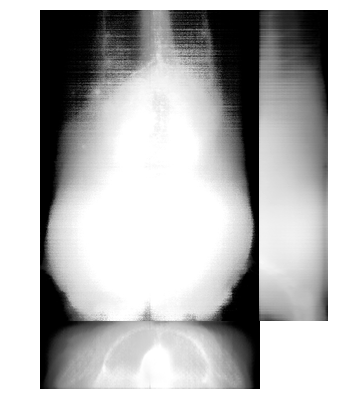

In [8]:
from fish.image.vol import proj_plot
mask = ref > 103
proj_plot(mask, np.mean, aspect=aspect);

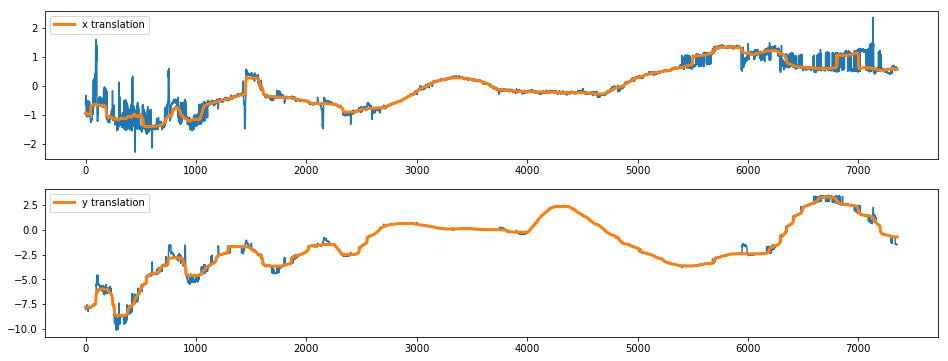

In [9]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

In [10]:
# Estimate the background pixe levels using the peak of the histogram of the reference image
hist = np.histogram(ref.ravel()[::100], np.arange(ref.min(), ref.max()))
fill_val = np.round(hist[1][np.argmax(hist[0])])

In [11]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val), with_keys=True).astype('float32')

In [12]:
%%time
fs_im = 2
baseline_window = int(300 / fs_im)
baseline_offset = 10
ds = 4

# subtract camera background
ims_registered = ims_registered.map(lambda v: np.clip(v - fill_val, a_min=0, a_max=None))

# uniform filter
ser = ims_registered.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds].toseries()

# take dff
ser = ser.normalize(method = 'window', window=baseline_window, offset=baseline_offset).astype('float32')
bounds = ser.map(lambda v: (v.min(), v.max())).toarray()

CPU times: user 38.9 s, sys: 2.74 s, total: 41.6 s
Wall time: 48min 1s


In [15]:
def rescale(v, in_range, out_range):    
    in_ptp = in_range[1] - in_range[0]
    out_ptp = out_range[1] - out_range[0]    
    rescaled = (((v - in_range[0]) * out_ptp) / in_ptp) + out_range[0]        
    return rescaled

# save the images
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

In [18]:
%%time
out_range = (0, 4096)
mn, mx = bounds.min(), bounds.max()
dff_ims = ser.toimages().map(lambda v: rescale(v, (mn,mx), out_range)).astype('int16')

from os.path import exists
from os import makedirs
if not exists(paths['output']):
    makedirs(paths['output'])

dff_ims.tordd().foreach(lambda v: save_ims(v, paths['output']))

CPU times: user 1.15 s, sys: 224 ms, total: 1.38 s
Wall time: 17min 7s


In [20]:
output_fnames = glob(paths['output'] + '*.tif')

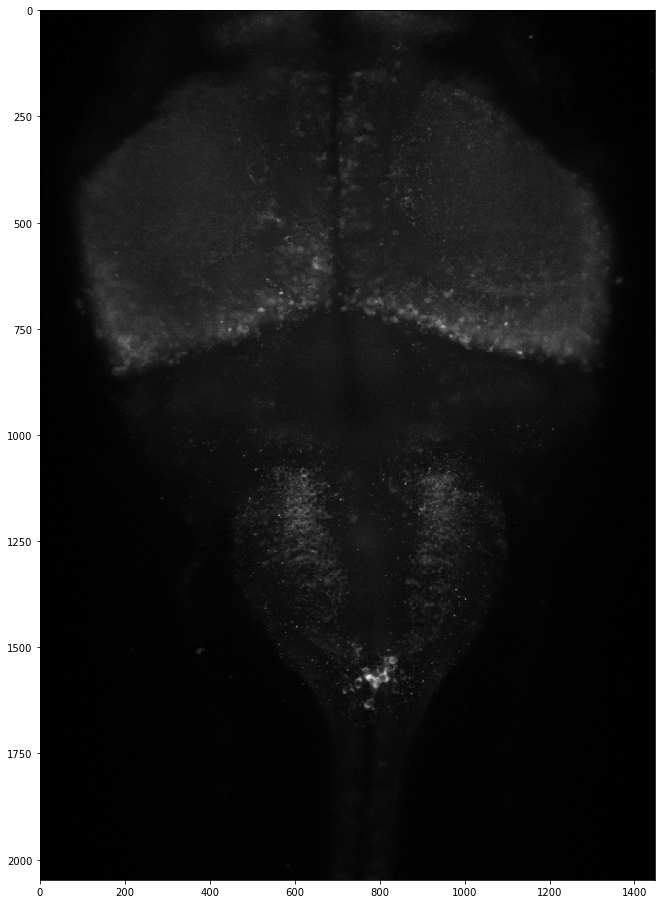

In [38]:
plt.figure(1,(16,16))
sample = load_image(fnames[1000])
plt.imshow(sample.max(0), cmap='gray')